## Model 3

### Sprint 3

#               <h1><center>Lenders Club Loan Grade and Subgrade Defining Application</center></h1>
## <h2><center>Loan Risk Assessment</center></h2>    


# Table of Content
I.	Introduction.

II.	Data loading

III.	Exploratory data analysis.

IV.	Statistical Inference.

V.	Modeling.

VI.	Conclusions.

VII.	Recommendations.




# I. Introduction

The goal of this project is to create a web service for predicting Lenders Club potential client risk Grade or Subgrade. 

In addition, this project aims to:
1.	To analyze what were the potential criteria for rejecting the loan in the past.
2.  Practice identifying opportunities for data analysis, raising hypothesis, and formulating research tasks.
2.	Practice performing EDA, statistical inference, and prediction.
3.	Practice visualizing data.
4.  Practice machine learning modeling techniques.
5.  Practicing deploying the model for production in Google Cloud Service.



Importing all the necessary libraries

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.preprocessing import  LabelEncoder, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from scipy.stats import ttest_ind
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from collections import Counter
import pickle
import shap
import category_encoders as ce
from lenders_functions import evaluate_log_reg, reduced_evaluate_models, evaluate_models
import numpy_financial as npf
from sklearn.inspection import permutation_importance

import warnings

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)


# II.	Data loading

In [ ]:
reject = pd.read_csv("reject.csv")

In [117]:
data = pd.read_csv("accept.csv")

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


# III. Exploratory data analysis

In EDA I will focus on the following project questions

1. Create a joined dataset for model, which may classify loans into accepted and rejected based on the limited amount of data that the rejected dataset provides.
2. Perform duplicate, missing values, outlier, and visual analysis for the newly created dataset.
3. Using 'Accept' dataset, create a dataset that would contain applicable information for new client's risk clasification, by eliminating features that appeared in the dataset after the loan was already issued - thus, strying to avoid data leakage.
4. Perform duplicate, missing values, outlier, and visual analysis for the newly created dataset.
5. Summary Statistics: Calculate descriptive statistics for numerical columns, such as mean, median, standard deviation, minimum, maximum, and quartiles. You can use the describe() function in pandas on a shortened "Accepted" loan dataset.
6. Feature Relationships: Explore relationships between different features/columns in the "Acceopt" dataset. Use correlation matrices or pair plots to visualize correlations in relation to target variables.

## III.1. Creating a joined dataset from Reject and Accept datasets.
Since the Reject dataset is much narrower in terms of features, I will have to use it as a reference point for picking features from Accept table.

3. Using 'Accept' dataset, create a dataset that would contain applicable information for new client's risk clasification, by eliminating features that appeared in the dataset after the loan was already issued - thus, strying to avoid data leakage.

In [2]:
reject.head()

Amount Requested Application Date                        Loan Title  \
0            1000.0       2007-05-26  Wedding Covered but No Honeymoon   
1            1000.0       2007-05-26                Consolidating Debt   
2           11000.0       2007-05-27       Want to consolidate my debt   
3            6000.0       2007-05-27                           waksman   
4            1500.0       2007-05-27                            mdrigo   

   Risk_Score Debt-To-Income Ratio Zip Code State Employment Length  \
0       693.0                  10%    481xx    NM           4 years   
1       703.0                  10%    010xx    MA          < 1 year   
2       715.0                  10%    212xx    MD            1 year   
3       698.0               38.64%    017xx    MA          < 1 year   
4       509.0                9.43%    209xx    MD          < 1 year   

   Policy Code  
0          0.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [3]:
reject['decision'] = "rejected"
columns_to_drop = ['Loan Title','Zip Code','Policy Code']
reject.drop(columns_to_drop, axis=1, inplace=True)
reject.head()

Amount Requested Application Date  Risk_Score Debt-To-Income Ratio State  \
0            1000.0       2007-05-26       693.0                  10%    NM   
1            1000.0       2007-05-26       703.0                  10%    MA   
2           11000.0       2007-05-27       715.0                  10%    MD   
3            6000.0       2007-05-27       698.0               38.64%    MA   
4            1500.0       2007-05-27       509.0                9.43%    MD   

  Employment Length  decision  
0           4 years  rejected  
1          < 1 year  rejected  
2            1 year  rejected  
3          < 1 year  rejected  
4          < 1 year  rejected

Before joing with the accept data, I will match the names of the columns.

In [4]:
column_mapping = {
    'Amount Requested': 'loan_amnt',
    'Application Date': 'issue_d',
    'Debt-To-Income Ratio': 'dti',
    'State': 'addr_state',
    'Employment Length': 'emp_length'
    }
reject.rename(columns = column_mapping, inplace=True)


In [5]:
#working with the date format
reject['year'] = pd.to_datetime(reject['issue_d']).dt.year
reject['month'] = pd.to_datetime(reject['issue_d']).dt.month
reject.drop('issue_d', axis=1, inplace = True)

In [6]:
# Changing employment length values to numeric
emp_length_map = {
    '10+ years': 10,
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
}
reject['emp_length'] = reject['emp_length'].map(emp_length_map)
reject['dti'] = reject['dti'].str.replace('%', '').astype(float)
reject.head()

loan_amnt  Risk_Score    dti addr_state  emp_length  decision  year  month
0     1000.0       693.0  10.00         NM         4.0  rejected  2007      5
1     1000.0       703.0  10.00         MA         0.0  rejected  2007      5
2    11000.0       715.0  10.00         MD         1.0  rejected  2007      5
3     6000.0       698.0  38.64         MA         0.0  rejected  2007      5
4     1500.0       509.0   9.43         MD         0.0  rejected  2007      5

As reject tables is prepared, I will move on with accept data. First - read, then check for duplicates, and then shorten it accoring to existing reject features.

In [7]:
data.head()

Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  68407277        NaN     3600.0       3600.0           3600.0   36 months   
1  68355089        NaN    24700.0      24700.0          24700.0   36 months   
2  68341763        NaN    20000.0      20000.0          20000.0   60 months   
3  66310712        NaN    35000.0      35000.0          35000.0   60 months   
4  68476807        NaN    10400.0      10400.0          10400.0   60 months   

   int_rate  installment grade sub_grade                    emp_title  \
0     13.99       123.03     C        C4                      leadman   
1     11.99       820.28     C        C1                     Engineer   
2     10.78       432.66     B        B4                 truck driver   
3     14.85       829.90     C        C5  Information Systems Officer   
4     22.45       289.91     F        F1          Contract Specialist   

  emp_length home_ownership  annual_inc verification_status   issue_d  \
0  10+ years       MORTGAGE     55000.0        Not Verified  Dec-2015   
1  10+ years       MORTGAGE     65000.0        Not Verified  Dec-2015   
2  10+ years       MORTGAGE     63000.0        Not Verified  Dec-2015   
3  10+ years       MORTGAGE    110000.0     Source Verified  Dec-2015   
4    3 years       MORTGAGE    104433.0     Source Verified  Dec-2015   

  loan_status pymnt_plan                                                url  \
0  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
1  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
2  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   
3     Current          n  https://lendingclub.com/browse/loanDetail.acti...   
4  Fully Paid          n  https://lendingclub.com/browse/loanDetail.acti...   

  desc             purpose               title zip_code addr_state    dti  \
0  NaN  debt_consolidation  Debt consolidation    190xx         PA   5.91   
1  NaN      small_business            Business    577xx         SD  16.06   
2  NaN    home_improvement                 NaN    605xx         IL  10.78   
3  NaN  debt_consolidation  Debt consolidation    076xx         NJ  17.06   
4  NaN      major_purchase      Major purchase    174xx         PA  25.37   

   delinq_2yrs earliest_cr_line  fico_range_low  fico_range_high  \
0          0.0         Aug-2003           675.0            679.0   
1          1.0         Dec-1999           715.0            719.0   
2          0.0         Aug-2000           695.0            699.0   
3          0.0         Sep-2008           785.0            789.0   
4          1.0         Jun-1998           695.0            699.0   

   inq_last_6mths  mths_since_last_delinq  mths_since_last_record  open_acc  \
0             1.0                    30.0                     NaN       7.0   
1             4.0                     6.0                     NaN      22.0   
2             0.0                     NaN                     NaN       6.0   
3             0.0                     NaN                     NaN      13.0   
4             3.0                    12.0                     NaN      12.0   

   pub_rec  revol_bal  revol_util  total_acc initial_list_status  out_prncp  \
0      0.0     2765.0        29.7       13.0                   w       0.00   
1      0.0    21470.0        19.2       38.0                   w       0.00   
2      0.0     7869.0        56.2       18.0                   w       0.00   
3      0.0     7802.0        11.6       17.0                   w   15897.65   
4      0.0    21929.0        64.5       35.0                   w       0.00   

   out_prncp_inv   total_pymnt  total_pymnt_inv  total_rec_prncp  \
0           0.00   4421.723917          4421.72          3600.00   
1           0.00  25679.660000         25679.66         24700.00   
2           0.00  22705.924294         22705.92         20000.00   
3       15897.65  31464.010000         31464.01         19102.35   
4           0.00  1

In [8]:
# cheking for duplicates 
duplicate_ids = data[data["id"].duplicated(keep=False)]
if duplicate_ids.empty:
    print("There are no duplicate ids in the dataset")
else:
    print("There are duplicate ids in the dataset")

There are no duplicate ids in the dataset


Based in the Reject table, the following columns should be picked from the Accept table: 'loan_amnt','issue_d', 'fico_range_low', 'fico_range_high', 'dti', 'zip_code','emp_length'.

In [9]:
accept_columns =['loan_amnt','issue_d', 'fico_range_low', 'fico_range_high', 'dti', 'addr_state','emp_length']
accept = data[accept_columns].copy()
accept['decision'] = "approved"
accept.head()

loan_amnt   issue_d  fico_range_low  fico_range_high    dti addr_state  \
0     3600.0  Dec-2015           675.0            679.0   5.91         PA   
1    24700.0  Dec-2015           715.0            719.0  16.06         SD   
2    20000.0  Dec-2015           695.0            699.0  10.78         IL   
3    35000.0  Dec-2015           785.0            789.0  17.06         NJ   
4    10400.0  Dec-2015           695.0            699.0  25.37         PA   

  emp_length  decision  
0  10+ years  approved  
1  10+ years  approved  
2  10+ years  approved  
3  10+ years  approved  
4    3 years  approved

In the reject table, Risk Score is a single column, while Accept one has two - high and low. For the sake of unification, I will calculate the average of both.

In [10]:
accept['Risk_Score'] = (accept['fico_range_low']+accept['fico_range_high'])/2
columns_to_drop = ['fico_range_low','fico_range_high']
accept.drop(columns_to_drop, axis=1, inplace=True)
accept.head()


loan_amnt   issue_d    dti addr_state emp_length  decision  Risk_Score
0     3600.0  Dec-2015   5.91         PA  10+ years  approved       677.0
1    24700.0  Dec-2015  16.06         SD  10+ years  approved       717.0
2    20000.0  Dec-2015  10.78         IL  10+ years  approved       697.0
3    35000.0  Dec-2015  17.06         NJ  10+ years  approved       787.0
4    10400.0  Dec-2015  25.37         PA    3 years  approved       697.0

In [11]:
#working with the date format
accept['year'] = pd.to_datetime(accept['issue_d']).dt.year
accept['month'] = pd.to_datetime(accept['issue_d']).dt.month
accept['year'] = accept['year'].fillna(0).astype(int)
accept['month'] = accept['month'].fillna(0).astype(int)
accept.drop('issue_d', axis=1, inplace = True)
accept.head()

loan_amnt    dti addr_state emp_length  decision  Risk_Score  year  month
0     3600.0   5.91         PA  10+ years  approved       677.0  2015     12
1    24700.0  16.06         SD  10+ years  approved       717.0  2015     12
2    20000.0  10.78         IL  10+ years  approved       697.0  2015     12
3    35000.0  17.06         NJ  10+ years  approved       787.0  2015     12
4    10400.0  25.37         PA    3 years  approved       697.0  2015     12

In [12]:
# Changing employment length values to numeric
emp_length_map = {
    '10+ years': 10,
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
}
accept['emp_length'] = accept['emp_length'].map(emp_length_map)
accept.head()

loan_amnt    dti addr_state  emp_length  decision  Risk_Score  year  month
0     3600.0   5.91         PA        10.0  approved       677.0  2015     12
1    24700.0  16.06         SD        10.0  approved       717.0  2015     12
2    20000.0  10.78         IL        10.0  approved       697.0  2015     12
3    35000.0  17.06         NJ        10.0  approved       787.0  2015     12
4    10400.0  25.37         PA         3.0  approved       697.0  2015     12

In [13]:
decision_data = pd.concat([accept, reject], axis=0, ignore_index = True)
decision_data.head()

loan_amnt    dti addr_state  emp_length  decision  Risk_Score  year  month
0     3600.0   5.91         PA        10.0  approved       677.0  2015     12
1    24700.0  16.06         SD        10.0  approved       717.0  2015     12
2    20000.0  10.78         IL        10.0  approved       697.0  2015     12
3    35000.0  17.06         NJ        10.0  approved       787.0  2015     12
4    10400.0  25.37         PA         3.0  approved       697.0  2015     12

## III.2. Perform duplicate, missing values, outlier, and visual analysis for the newly created dataset.

### III.2.1. Perform duplicate review and handling missing values.

In [14]:
decision_data.count()

loan_amnt     29909409
dti           29907698
addr_state    29909387
emp_length    28811147
decision      29909442
Risk_Score    11411779
year          29909442
month         29909442
dtype: int64

In [15]:
decision_data['decision'].value_counts()

rejected    27648741
approved     2260701
Name: decision, dtype: int64

In [16]:
reject.count()

loan_amnt     27648741
Risk_Score     9151111
dti           27648741
addr_state    27648719
emp_length    26697386
decision      27648741
year          27648741
month         27648741
dtype: int64

In [17]:
accept.count()

loan_amnt     2260668
dti           2258957
addr_state    2260668
emp_length    2113761
decision      2260701
Risk_Score    2260668
year          2260701
month         2260701
dtype: int64

Risk Score is significantly missing value in the combined dataset. This value is derivative from all the other available data, such as income, other loans, credit history, and new loan parameters. We have quite a few important features to define the risk score in the acccept dataset, but not in the reject. In addition, most of the missing risk scores are in the reject dataset, which is already 12 times larger than the accept dataset. Thus, I decided to delete all the rows with the missing risc score value, which may help me balance the dataset in the further steps.

In [18]:
decision_data = decision_data.dropna(subset='Risk_Score')
decision_data.count()

loan_amnt     11411779
dti           11410068
addr_state    11411760
emp_length    11106356
decision      11411779
Risk_Score    11411779
year          11411779
month         11411779
dtype: int64

After reducing the dataset by the missing Risk_Score values, I still have one feature with missing values - employment length. Since this is one of the potentially the most important features that is not derived but provided by borrowers, I think it is important. However, I will check it against the target variable - decision. 

In [19]:
count_nan_by_decision = decision_data[decision_data['emp_length'].isna()].groupby('decision').size().reset_index(name='count')
count_nan_by_decision

decision   count
0  approved  146907
1  rejected  158516

Seems like there are almost equal number of missing employment information in both groups. Although the feature is important, the dataset is large enough for me to simply drop the missing values. Performing data imputation would make more sense if the dataset was small enough and also, if there were more features available that would influence the imputation.

In addition dti and state va

In [20]:
decision_data = decision_data.dropna(subset='emp_length')
decision_data = decision_data.dropna(subset='dti')
decision_data = decision_data.dropna(subset='addr_state')
decision_data.count()

loan_amnt     11106224
dti           11106224
addr_state    11106224
emp_length    11106224
decision      11106224
Risk_Score    11106224
year          11106224
month         11106224
dtype: int64

### III.2.2. Visual analysis and handling the outliers.
Now, I have a clean dataset with no duplicates and missing values. I will move on to graphic review and handling the outliers if they exist.

First, I will split clean dataset into accepted and rejected groups. Then, I will identify numeric and categorical features and analize them separately.

In [21]:
decision_data.dtypes

loan_amnt     float64
dti           float64
addr_state     object
emp_length    float64
decision       object
Risk_Score    float64
year            int64
month           int64
dtype: object

In [22]:
decision_data['dti'] = pd.to_numeric(decision_data['dti'], errors = 'coerce')
decision_data['dti'].dtypes

dtype('float64')

In [23]:
accept_clean = decision_data[decision_data["decision"] == 'approved']
reject_clean = decision_data[decision_data["decision"] == 'rejected']
print(f"Accepted loans make {len(accept_clean )} cases.")
print(f"Rejected loans make {len(reject_clean )} cases.")
print(
    f"Accepted loans makes {len(accept_clean)/len(decision_data)*100:.2f} % of the total dataset."
)

Accepted loans make 2113648 cases.
Rejected loans make 8992576 cases.
Accepted loans makes 19.03 % of the total dataset.


In [24]:
cat_cols = ['addr_state', 'emp_length', 'decision', 'year', 'month']
num_cols = ['loan_amnt', 'dti', 'Risk_Score']


The initial efforts to draw histograms did not provide any fruit because all features, especially in the rejected table, had many outliers. So I decided to remove the outliers for the visualization purposes. While I might leave them in the modeling part.

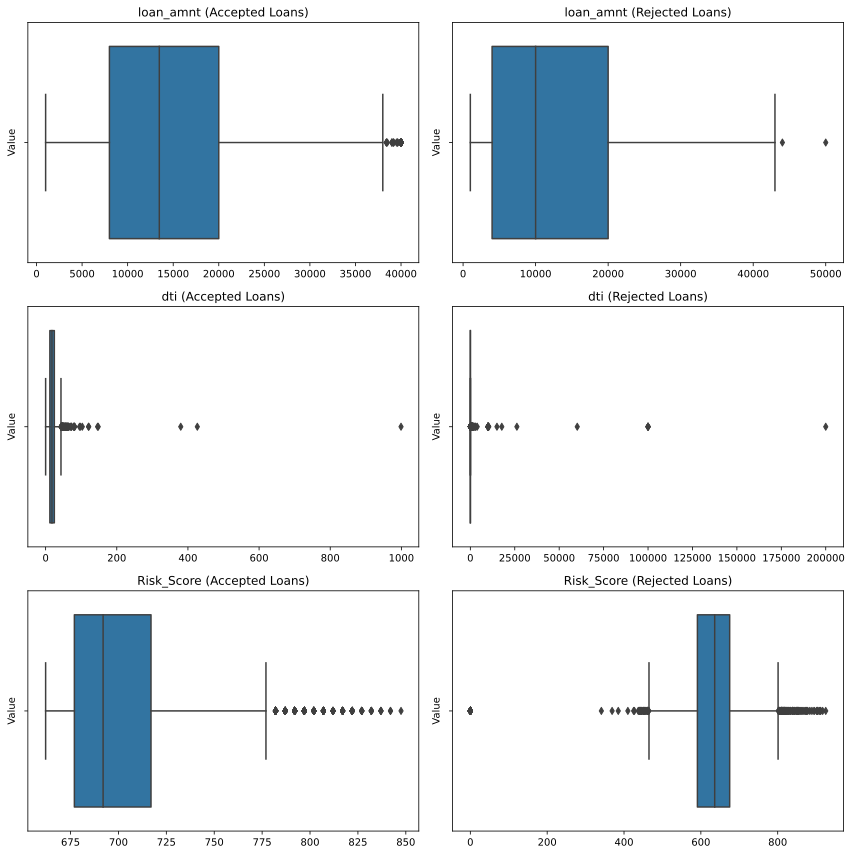

In [25]:
num_cols = ['loan_amnt', 'dti', 'Risk_Score']

sample_size = 10000


accept_sample = accept_clean.sample(n=sample_size, random_state=42)
reject_sample = reject_clean.sample(n=sample_size, random_state=42)


fig, axes = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(12, 4 * len(num_cols)))


for i, col in enumerate(num_cols):
    sns.boxplot(data=accept_sample, x=col, ax=axes[i, 0])
    sns.boxplot(data=reject_sample, x=col, ax=axes[i, 1])

    axes[i, 0].set_title(f'{col} (Accepted Loans)')
    axes[i, 1].set_title(f'{col} (Rejected Loans)')
    axes[i, 0].set_xlabel('')
    axes[i, 1].set_xlabel('')
    axes[i, 0].set_ylabel('Value')
    axes[i, 1].set_ylabel('Value')

plt.tight_layout()

plt.show()

In [26]:
def remove_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

for col in num_cols:
    accept_clean = remove_outliers_iqr(accept_clean, col)
    reject_clean = remove_outliers_iqr(reject_clean, col)

In [27]:
sample_size = 1000000


accept_sample = accept_clean.sample(n=sample_size, random_state=42)
reject_sample = reject_clean.sample(n=sample_size, random_state=42)


fig, axes = plt.subplots(nrows=len(num_cols), ncols=2, figsize=(12, 4 * len(num_cols)))


for i, col in enumerate(num_cols):
    sns.boxplot(data=accept_sample, x=col, ax=axes[i, 0])
    sns.boxplot(data=reject_sample, x=col, ax=axes[i, 1])

    axes[i, 0].set_title(f'{col} (Accepted Loans)')
    axes[i, 1].set_title(f'{col} (Rejected Loans)')
    axes[i, 0].set_xlabel('')
    axes[i, 1].set_xlabel('')
    axes[i, 0].set_ylabel('Value')
    axes[i, 1].set_ylabel('Value')

plt.tight_layout()

plt.show()

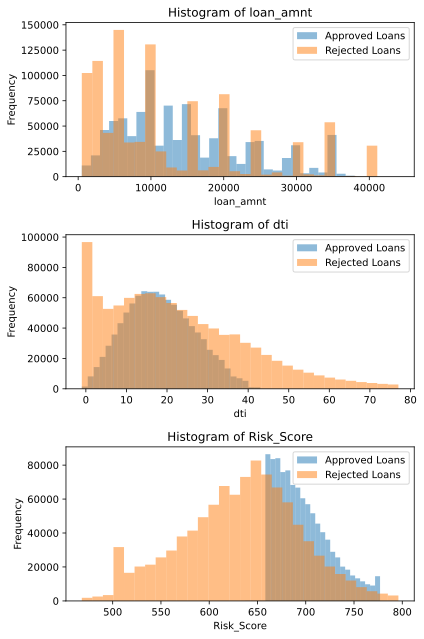

In [28]:
rows = len(num_cols)
cols = 1
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(6,3*rows))
bins = 30
for idx, col in enumerate(num_cols):
    ax=axes[idx]
    accept_sample[col].plot(kind='hist', ax=ax, alpha=0.5, label='Approved Loans', bins = bins)
    reject_sample[col].plot(kind='hist', ax=ax, alpha=0.5, label='Rejected Loans', bins = bins)
    
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.legend()


plt.tight_layout()
plt.show()

After cleaning the outliers and doing a visual analysis of the numeric features that are available in the unified datasets, I can initially say that numeric data is not enough for having a clear separation between the accepted and reject loans characteristics. One thing is clear, before the removal of the outliers is that there were much more outliers in the loan amount in the rejected  group, which points that quite a few rejections came because of the too big loan requests. DTI and risk score values are both derivatives. While we may be able the needed values from the accept table, it won't let us make objective comparison with the rejected loans. On the other hand, one pattern is very clear that there is a certain threshold for risc score (FICO) for the approved loans - which is ~660.


Now lets make a visual analysis of the categorical features. 

Fist, I will choose top 10 states with the highest accepted loan percentage and then top 10 with the lowest. 

In [30]:
def grouping(data, group_col):
    df = data.groupby(group_col)['decision'].value_counts().unstack()
    df.reset_index(inplace=True)
    return df

In [31]:
def percentaging(data):
    df = data
    df['total'] = df['approved']+df['rejected']
    df['a%'] = round((df['approved']/df['total'])*100,1)
    df['r%'] = round((df['rejected']/df['total'])*100,1)
    df = df.drop(columns=['approved', 'rejected', 'total'])
    df.rename(columns = {'a%':'approved', 'r%':'rejected'}, inplace=True)
    return df

In [32]:
grouped_states = grouping(decision_data, 'addr_state')
grouped_states.head()

decision addr_state  approved  rejected
0                AK      4984     20194
1                AL     25015    160865
2                AR     15476     96858
3                AZ     49384    189253
4                CA    296375   1090965

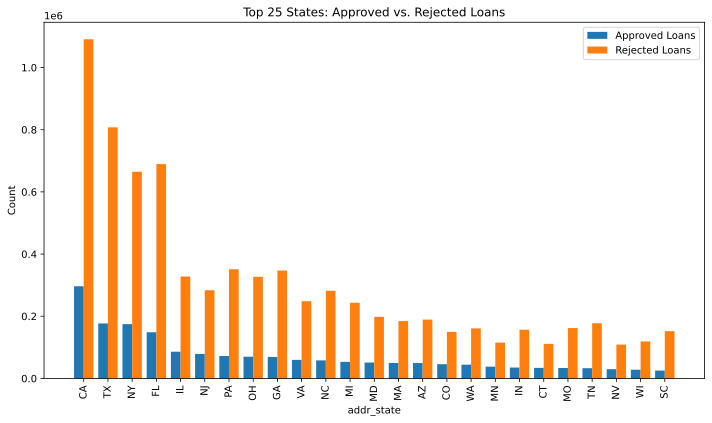

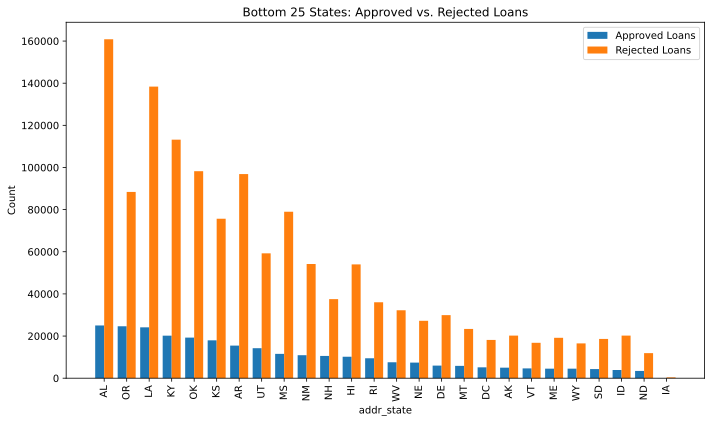

In [34]:
grouped_states = grouped_states.sort_values(by='approved', ascending=False)
top_states = grouped_states[:25]
bottom_states = grouped_states[25:]

def plot_bar_chart(data, grouping_col, title):
    group = data[grouping_col]
    approved_loans = data['approved']
    rejected_loans = data['rejected']

    bar_width = 0.4

    x = np.arange(len(group))

    plt.figure(figsize=(10, 6))
    plt.bar(x - bar_width/2, approved_loans, width=bar_width, label='Approved Loans', align='center')
    plt.bar(x + bar_width/2, rejected_loans, width=bar_width, label='Rejected Loans', align='center')

    plt.xticks(x, group, rotation=90)

    plt.xlabel(grouping_col)
    plt.ylabel('Count')
    plt.title(title)
    
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the top 25 states
plot_bar_chart(top_states, 'addr_state', 'Top 25 States: Approved vs. Rejected Loans')

# Plot the bottom 25 states
plot_bar_chart(bottom_states, 'addr_state', 'Bottom 25 States: Approved vs. Rejected Loans')

In [35]:
grouped_states_percentage = percentaging(grouped_states)
grouped_states_percentage.head()

decision addr_state  approved  rejected
4                CA      21.4      78.6
43               TX      17.9      82.1
34               NY      20.8      79.2
9                FL      17.7      82.3
14               IL      20.8      79.2

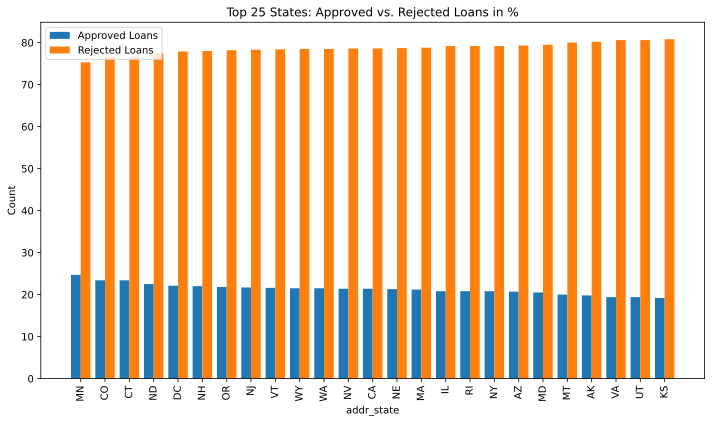

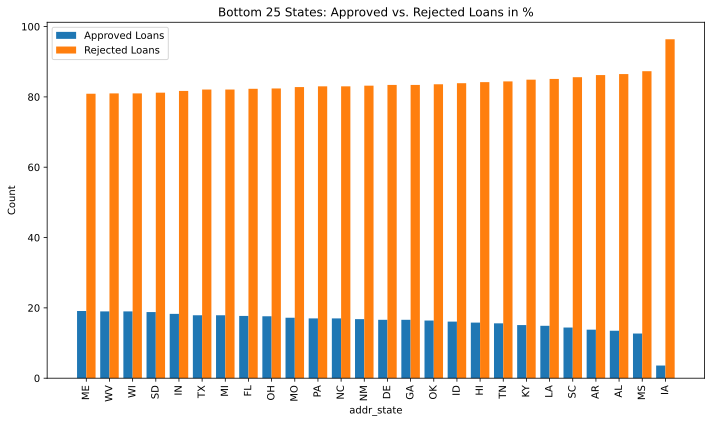

In [36]:
grouped_states_percentage = grouped_states_percentage.sort_values(by='approved', ascending=False)
top_states_percentage = grouped_states_percentage[:25]
bottom_states_percentage = grouped_states_percentage[25:]


plot_bar_chart(top_states_percentage, 'addr_state', 'Top 25 States: Approved vs. Rejected Loans in %')

# Plot the bottom 25 states
plot_bar_chart(bottom_states_percentage,'addr_state', 'Bottom 25 States: Approved vs. Rejected Loans in %')

Despite the fact that most loan requests came from California, Texas, and New York, they are far from the top 3 of the positive loan decision in terms of proportions. Which points to the assumption that the place of the loan being issued is not related to the most populated and well-off considered states, but other criteria, which still has to be discovered.

No I will check if there is a difference in the percentage of approved loans based on the year of issuance and also if there is some sort of seasonality in months. For that I will groupby decision data table by year first, and then by months.

In [37]:
grouped_years = grouping(decision_data, 'year')
grouped_years_percents = percentaging(grouped_years)
grouped_years_percents.head()

decision  year  approved  rejected
0         2007      10.4      89.6
1         2008       9.4      90.6
2         2009       9.4      90.6
3         2010      10.7      89.3
4         2011       9.0      91.0

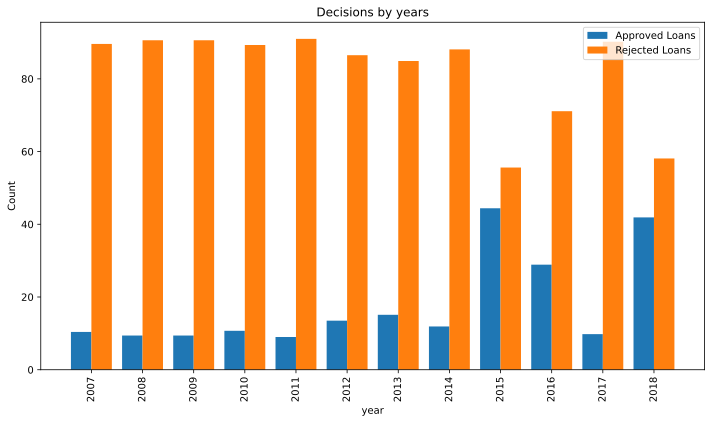

In [38]:
grouped_years_percents = grouped_years_percents.sort_values(by='year', ascending=True)

plot_bar_chart(grouped_years_percents, 'year', 'Decisions by years')


Again, looking at the decision by years, there is no clear tendency - e.g. significant increase in positive decisions in 2015 was followed by the fall next year. In 2017, the rejection level reached the first five years level. Thus, visually, I cannot identify significant relationship between the year and positive loan decisions.

Let's look if there is any seasonality by months, now.

In [39]:

grouped_months = grouping(decision_data, 'month')
grouped_months_percents = percentaging(grouped_months)
grouped_months_percents.head()

decision  month  approved  rejected
0             1      13.6      86.4
1             2      20.5      79.5
2             3      25.1      74.9
3             4      24.4      75.6
4             5      24.0      76.0

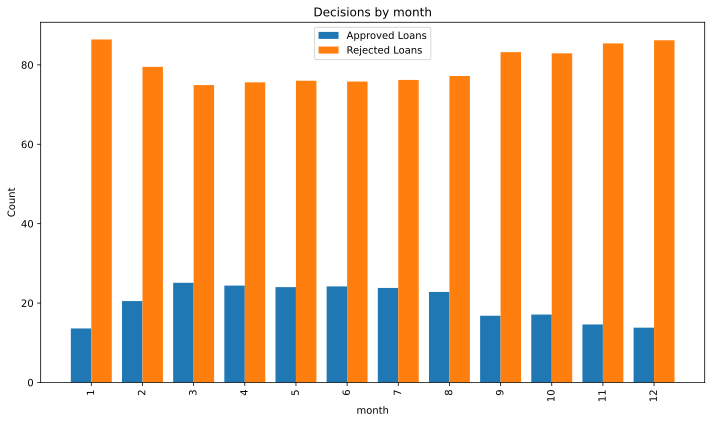

In [40]:
grouped_months_percents = grouped_months_percents.sort_values(by='month', ascending=True)
plot_bar_chart(grouped_months_percents, 'month', 'Decisions by month')

Some seasonality can be observed during the warmer season. However, does it really have any significant effect on decision - I am not sure, yet.

Finally, I will look at the work length category. Intuitively, I believe that this one may have some relationship to the decision to grant the loan or not.

In [41]:
grouped_emp = grouping(decision_data, 'emp_length')
grouped_emp_percents = percentaging(grouped_emp)
grouped_emp_percents.head()

decision  emp_length  approved  rejected
0                0.0       2.3      97.7
1                1.0      66.2      33.8
2                2.0      72.2      27.8
3                3.0      72.9      27.1
4                4.0      73.3      26.7

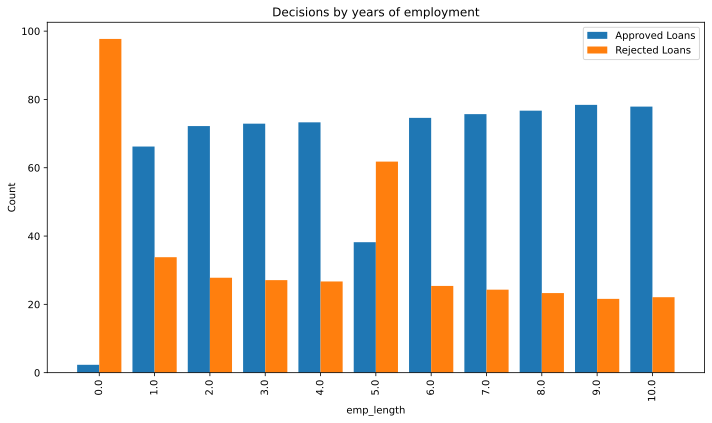

In [42]:
grouped_emp_percents = grouped_emp_percents.sort_values(by='emp_length', ascending=True)
plot_bar_chart(grouped_emp_percents, 'emp_length', 'Decisions by years of employment')

Surprizingly even employment length does not seem to represent a clear visual relationship to the credit decision. The only clear tendency is that those who have less than 1 year of employment, have clearly little chance of getting the loan approval.

Now, I will perform correlation analysis, and see if it confirms my asumptions, that the limited data we have in the rejected table, is not sufficient to categorize the loans.

In [43]:
decision_data['decision'] = decision_data['decision'].map({'approved': 1, 'rejected': 0})
label_encoder = LabelEncoder()
decision_data['addr_state'] = label_encoder.fit_transform(decision_data['addr_state'])
decision_data.head()

loan_amnt    dti  addr_state  emp_length  decision  Risk_Score  year  month
0     3600.0   5.91          38        10.0         1       677.0  2015     12
1    24700.0  16.06          41        10.0         1       717.0  2015     12
2    20000.0  10.78          14        10.0         1       697.0  2015     12
3    35000.0  17.06          31        10.0         1       787.0  2015     12
4    10400.0  25.37          38         3.0         1       697.0  2015     12

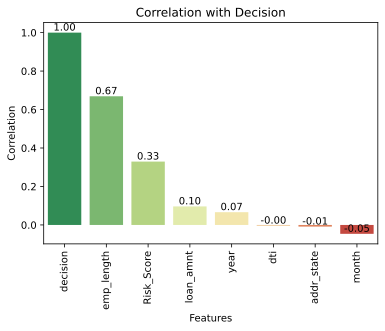

In [45]:
corr = decision_data.corr()['decision'].sort_values(ascending=False)
plt.figure(figsize=(6, 4))
barplot = sns.barplot(x=corr.index, y=corr.values, palette="RdYlGn_r")
plt.xticks(rotation=90)
plt.title('Correlation with Decision')
plt.xlabel('Features')
plt.ylabel('Correlation')
for index, value in enumerate(corr.values):
    barplot.text(index, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()


The correlation of employment length to decision is quite high. Address state and risck score seems to have moderate correlation. While employment length make sense, the state address does not. I will check this with statistical significance between address state and the decision using standard t-test. 

Null Hypothesis (H0): There is no significant association between the borrowers address state and the decsion on loan being issued.

Alternative Hypothesis (H1): There is a significant association between the borrowers address state and the decsion on loan being issued.

Alpha = 0.05

In [46]:
approved_decision = decision_data[decision_data['decision'] == 1]
reject_decision = decision_data[decision_data['decision'] == 0]

health_factors = ['hypertension', 'heart_disease', 'avg_glucose_level']
results = {}

t_stat, p_value = ttest_ind(approved_decision['addr_state'], reject_decision['addr_state'])
results = {'t_statistic': t_stat, 'p_value': p_value}


print(f"Address state of the borrower")
print(f"T-Statistic: {results['t_statistic']:.4f}")
print(f"P-Value: {results['p_value']:.4f}")
print("")

if results['p_value'] < 0.05:
    print(f"The address state is statistically significant in relation to decision.")
else:
    print(f"The address state is not statistically significant in relation to decision.")
print("=============================")

Address state of the borrower
T-Statistic: -28.5702
P-Value: 0.0000

The address state is statistically significant in relation to decision.


We have at least two parameters that are not derived, but user provided that show some significance to the decision on the loan - employment length and address state. Risk score is also statistically significant parameter but it is deirived from the other inputs which are not provided. The other parameter that has weaker correlation is the loan amount. I will drop year and month, and also dti parameter, which should be quite significant becuase of its purpose. However, this parameter is derivative, and we do not have the values from which it was derived in the rejected part of the data set. So, I will use a simple logistics regression model, to see if we can accuratelly predict loan categorization between approved and rejected. First, I will use the predition on entire data set and then on selected parameters - length of employments, address state, and the loan amount.

In [48]:
result = evaluate_log_reg(decision_data, 'decision')

Accuracy: 0.88

Confusion Matrix:
[[1594410  203451]
 [  63431  359953]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92   1797861
           1       0.64      0.85      0.73    423384

    accuracy                           0.88   2221245
   macro avg       0.80      0.87      0.83   2221245
weighted avg       0.90      0.88      0.89   2221245



The result of the test is impresive, even though the data on which the model is built should not be sufficient. Now, I will test on the selected parameters only.

In [49]:
selected_params = ['loan_amnt',
 'addr_state',
 'emp_length',
 'decision'
 ]
selected_data = decision_data[selected_params].copy()
selected_data.head()

loan_amnt  addr_state  emp_length  decision
0     3600.0          38        10.0         1
1    24700.0          41        10.0         1
2    20000.0          14        10.0         1
3    35000.0          31        10.0         1
4    10400.0          38         3.0         1

In [50]:
result = evaluate_log_reg(selected_data, 'decision')

Accuracy: 0.89

Confusion Matrix:
[[1661701  136160]
 [ 104510  318874]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93   1797861
           1       0.70      0.75      0.73    423384

    accuracy                           0.89   2221245
   macro avg       0.82      0.84      0.83   2221245
weighted avg       0.90      0.89      0.89   2221245



Selected parameters showed basically the same result - slightly better. After trying to fit the model with all the different parameter combinations, i conclude that the only parameter, which is not derived, and which affects the model, is employment length. Althogh, this is an important parameter, this is clearly not enought to make a decision regarding the financing. 

Thus, I conclude, that there are not enough parameters is the provided rejected loans dataset, to predict the rejection or approval of the loan, even though the model shows quite good accuracy results.

I will focus now on the accepted loan data set, separate the parameters that should be the user input ones before making the loan decision to avoid the data leakage. 

## III.3. Creating an accpeted loan dataset with the intial user input parameters.

I will try separating the parameters that seemed to be the ones that user usually provides during the process of application. Based on the analysis of the dataset and the lendersclub.com online platform, I have idendified the following user input parameters:"loan_amnt", "emp_title", "emp_length", "home_ownership", "annual_inc", "issue_d", "purpose", "title", "zip_code", "addr_state", "application_type".

Other parameters are likely received from the external data sources, such as: "delinq_2yrs", "earliest_cr_line", "mths_since_last_delinq", "open_acc", "revol_bal", "revol_util", "total_acc", "out_prncp", "total_pymnt", "total_rec_prncp", "total_rec_late_fee", "recoveries", "collections_12_mths_ex_med", "mths_since_last_major_derog".

Or derived: "int_rate", "dti", "grade", "sub_grade", "fico_range_low", "fico_range_high", "policy_code".

There are many more different features that are in the accepted loans dataset, but most of them are from the lenders club database on the issued loan - monitoring its performance.

Since, I do not have access to the public records to check the individuals credit history, while testing the model with the 'user input' data, I predicts some of the parameters or asume them as user provided.

I will start with selecting all these columns in a new dataset.

In [118]:
columns_to_select = ['issue_d', "loan_amnt", 'term', "int_rate", "hardship_flag", "grade", "sub_grade", "emp_title", "emp_length", 
                     "home_ownership", "annual_inc", "purpose", "addr_state", "dti", "delinq_2yrs", 
                     "earliest_cr_line", "fico_range_low", "fico_range_high", "mths_since_last_delinq", 
                     "open_acc", "revol_bal", "revol_util", "total_acc", "out_prncp", "total_pymnt", 
                     "total_rec_prncp", "total_rec_late_fee", "recoveries", "collections_12_mths_ex_med", 
                     "mths_since_last_major_derog", "policy_code", "application_type"]
accept_data = data[columns_to_select]
accept_data.head()

issue_d  loan_amnt        term  int_rate hardship_flag grade sub_grade  \
0  Dec-2015     3600.0   36 months     13.99             N     C        C4   
1  Dec-2015    24700.0   36 months     11.99             N     C        C1   
2  Dec-2015    20000.0   60 months     10.78             N     B        B4   
3  Dec-2015    35000.0   60 months     14.85             N     C        C5   
4  Dec-2015    10400.0   60 months     22.45             N     F        F1   

                     emp_title emp_length home_ownership  annual_inc  \
0                      leadman  10+ years       MORTGAGE     55000.0   
1                     Engineer  10+ years       MORTGAGE     65000.0   
2                 truck driver  10+ years       MORTGAGE     63000.0   
3  Information Systems Officer  10+ years       MORTGAGE    110000.0   
4          Contract Specialist    3 years       MORTGAGE    104433.0   

              purpose addr_state    dti  delinq_2yrs earliest_cr_line  \
0  debt_consolidation         PA   5.91          0.0         Aug-2003   
1      small_business         SD  16.06          1.0         Dec-1999   
2    home_improvement         IL  10.78          0.0         Aug-2000   
3  debt_consolidation         NJ  17.06          0.0         Sep-2008   
4      major_purchase         PA  25.37          1.0         Jun-1998   

   fico_range_low  fico_range_high  mths_since_last_delinq  open_acc  \
0           675.0            679.0                    30.0       7.0   
1           715.0            719.0                     6.0      22.0   
2           695.0            699.0                     NaN       6.0   
3           785.0            789.0                     NaN      13.0   
4           695.0            699.0                    12.0      12.0   

   revol_bal  revol_util  total_acc  out_prncp   total_pymnt  total_rec_prncp  \
0     2765.0        29.7       13.0       0.00   4421.723917          3600.00   
1    21470.0        19.2       38.0       0.00  25679.660000         24700.00   
2     7869.0        56.2       18.0       0.00  22705.924294         20000.00   
3     7802.0        11.6       17.0   15897.65  31464.010000         19102.35   
4    21929.0        64.5       35.0       0.00  11740.500000         10400.00   

   total_rec_late_fee  recoveries  collections_12_mths_ex_med  \
0                 0.0         0.0                         0.0   
1                 0.0         0.0                         0.0   
2                 0.0         0.0                         0.0   
3                 0.0         0.0                         0.0   
4                 0.0         0.0                         0.0   

   mths_since_last_major_derog  policy_code application_type  
0                         30.0          1.0       Individual  
1                          NaN          1.0       Individual  
2                          NaN          1.0        Joint App  
3                          NaN          1.0       Individual  
4                          NaN          1.0       Individual

## III.4. Perform missing values, outlier, and visual analysis for the newly created dataset.
5. Summary Statistics: Calculate descriptive statistics for numerical columns, such as mean, median, standard deviation, minimum, maximum, and quartiles. You can use the describe() function in pandas on a shortened "Accepted" loan dataset.
6. Feature Relationships: Explore relationships between different features/columns in the "Acceopt" dataset. Use correlation matrices or pair plots to visualize correlations in relation to target variables.

In [52]:
total_records = len(accept_data)

missing_values = accept_data.isnull().sum()

percentage_missing = (missing_values / total_records) * 100

missing_data_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage Missing': percentage_missing})

columns_with_missing_values = missing_data_info[missing_data_info['Missing Values'] > 0]

print("Columns with Missing Values:")
print(columns_with_missing_values)

Columns with Missing Values:
                             Missing Values  Percentage Missing
issue_d                                  33            0.001460
loan_amnt                                33            0.001460
term                                     33            0.001460
int_rate                                 33            0.001460
hardship_flag                            33            0.001460
grade                                    33            0.001460
sub_grade                                33            0.001460
emp_title                            167002            7.387178
emp_length                           146940            6.499754
home_ownership                           33            0.001460
annual_inc                               37            0.001637
purpose                                  33            0.001460
addr_state                               33            0.001460
dti                                    1744            0.077144
delinq_2yrs

There are three types of missing data. First, there are 33 records missing in almost all rows -  these can be dropped. Second, from the previous analysis we have concluded that employment length is very important feature for possitive decision - this feature should be imputed. Third - missing values are in the columns where last missconduct been recorded - these should be replaced with the max amount available in the dataset or simply with any number that is above the max. 

Before imputing the employment length, I will check it against the job title.

In [53]:
nan_emp_length_df = accept_data[accept_data['emp_length'].isna()]

emp_title_counts = nan_emp_length_df['emp_title'].value_counts()

print("Unique values of 'emp_title' for rows with NaN 'emp_length':")
print(emp_title_counts)
del nan_emp_length_df
del emp_title_counts


Unique values of 'emp_title' for rows with NaN 'emp_length':
Owner                                       24
Driver                                      14
owner                                        9
Teacher                                      9
Manager                                      8
Substitute Teacher                           7
Sales Associate                              6
Retired                                      6
Cashier                                      5
Sales                                        5
sales                                        5
Security Officer                             5
Clerk                                        4
Instructor                                   4
Delivery Driver                              4
Consultant                                   4
Security                                     4
Mechanic                                     4
President                                    4
Bus Driver                                   4

It seems that the missing employment length is not associated with some kind of particular work function - it has not been provided by the user. I will check the missing employment information against the date, to see if there was a particular period where this information was not required.

In [121]:
accept_data['year'] = pd.to_datetime(accept_data['issue_d']).dt.year
accept_data['month'] = pd.to_datetime(accept_data['issue_d']).dt.month
accept_data['year'] = accept_data['year'].fillna(0).astype(int)
accept_data['month'] = accept_data['month'].fillna(0).astype(int)
accept_data.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

issue_d  loan_amnt        term  int_rate hardship_flag grade sub_grade  \
0  Dec-2015     3600.0   36 months     13.99             N     C        C4   
1  Dec-2015    24700.0   36 months     11.99             N     C        C1   
2  Dec-2015    20000.0   60 months     10.78             N     B        B4   
3  Dec-2015    35000.0   60 months     14.85             N     C        C5   
4  Dec-2015    10400.0   60 months     22.45             N     F        F1   

                     emp_title emp_length home_ownership  annual_inc  \
0                      leadman  10+ years       MORTGAGE     55000.0   
1                     Engineer  10+ years       MORTGAGE     65000.0   
2                 truck driver  10+ years       MORTGAGE     63000.0   
3  Information Systems Officer  10+ years       MORTGAGE    110000.0   
4          Contract Specialist    3 years       MORTGAGE    104433.0   

              purpose addr_state    dti  delinq_2yrs earliest_cr_line  \
0  debt_consolidation         PA   5.91          0.0         Aug-2003   
1      small_business         SD  16.06          1.0         Dec-1999   
2    home_improvement         IL  10.78          0.0         Aug-2000   
3  debt_consolidation         NJ  17.06          0.0         Sep-2008   
4      major_purchase         PA  25.37          1.0         Jun-1998   

   fico_range_low  fico_range_high  mths_since_last_delinq  open_acc  \
0           675.0            679.0                    30.0       7.0   
1           715.0            719.0                     6.0      22.0   
2           695.0            699.0                     NaN       6.0   
3           785.0            789.0                     NaN      13.0   
4           695.0            699.0                    12.0      12.0   

   revol_bal  revol_util  total_acc  out_prncp   total_pymnt  total_rec_prncp  \
0     2765.0        29.7       13.0       0.00   4421.723917          3600.00   
1    21470.0        19.2       38.0       0.00  25679.660000         24700.00   
2     7869.0        56.2       18.0       0.00  22705.924294         20000.00   
3     7802.0        11.6       17.0   15897.65  31464.010000         19102.35   
4    21929.0        64.5       35.0       0.00  11740.500000         10400.00   

   total_rec_late_fee  recoveries  collections_12_mths_ex_med  \
0                 0.0         0.0                         0.0   
1                 0.0         0.0                         0.0   
2                 0.0         0.0                         0.0   
3                 0.0         0.0                         0.0   
4                 0.0         0.0                         0.0   

   mths_since_last_major_derog  policy_code application_type  year  month  
0                         30.0          1.0       Individual  2015     12  
1                          NaN          1.0       Individual  2015     12  
2                          NaN          1.0        Joint App  2015     12  
3                          NaN          1.0       Individual  2015     12  
4                          NaN          1.0       Individual  2015     12

In [55]:
nan_emp_length_df = accept_data[accept_data['emp_length'].isna()]

year_counts = nan_emp_length_df['year'].value_counts()

print("Unique values of 'year' for rows with NaN 'emp_length':")
print(year_counts)
del nan_emp_length_df



Unique values of 'year' for rows with NaN 'emp_length':
2018    41987
2017    31871
2016    28214
2015    23817
2014    12019
2013     5962
2012     1925
2011      759
2010      353
0          33
Name: year, dtype: int64


No, there was no specific year where users could avoid providing their length of employment. On the other hand, we deal with the accepted dataset now, thus employment length does not seem to be crucial because other features might compensate for it, such as income, dti, and credit history information. Thus, instead of imputing the number, I leave it blank, and see how its presence can affect the credit score.

On the other hand, I will drop the rows that have less than 1% of missing values in most columns. In addition, I will replace the NaN for historical misconduct with either max or even more than max, depending, what the max number will be.

In [56]:
max_delinq = accept_data['mths_since_last_delinq'].max()
max_derog = accept_data['mths_since_last_major_derog'].max()
max_delinq,max_derog

(226.0, 226.0)

Since the max values are so high, meaning that the last credit misconduct happened 226 months ago, I will incpute 227 instead of NaN for both fields.

In [57]:
accept_data['mths_since_last_delinq'].fillna(227, inplace=True)
accept_data['mths_since_last_major_derog'].fillna(227, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
total_records = len(accept_data)
missing_values = accept_data.isnull().sum()
percentage_missing = (missing_values / total_records) * 100
missing_data_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage Missing': percentage_missing})
columns_with_missing_values = missing_data_info[missing_data_info['Percentage Missing'] < 1]
columns_to_drop = columns_with_missing_values.index.tolist()
accept_data = accept_data.dropna(subset=columns_to_drop, how='any')


In [59]:
accept_data['risk_score'] = (accept_data['fico_range_low']+accept_data['fico_range_high'])/2
columns_to_drop = ['fico_range_low','fico_range_high']
accept_data.drop(columns_to_drop, axis=1, inplace=True)

Now, I have relatively clean dataset, although some important data is missing. I will impute it later if needed.

I will focus now on the user input columns to analyze the categories and correct them as needed


In [60]:
accept_data.head()

issue_d  loan_amnt        term  int_rate hardship_flag grade sub_grade  \
0  Dec-2015     3600.0   36 months     13.99             N     C        C4   
1  Dec-2015    24700.0   36 months     11.99             N     C        C1   
2  Dec-2015    20000.0   60 months     10.78             N     B        B4   
3  Dec-2015    35000.0   60 months     14.85             N     C        C5   
4  Dec-2015    10400.0   60 months     22.45             N     F        F1   

                     emp_title emp_length home_ownership  annual_inc  \
0                      leadman  10+ years       MORTGAGE     55000.0   
1                     Engineer  10+ years       MORTGAGE     65000.0   
2                 truck driver  10+ years       MORTGAGE     63000.0   
3  Information Systems Officer  10+ years       MORTGAGE    110000.0   
4          Contract Specialist    3 years       MORTGAGE    104433.0   

              purpose addr_state    dti  delinq_2yrs earliest_cr_line  \
0  debt_consolidation         PA   5.91          0.0         Aug-2003   
1      small_business         SD  16.06          1.0         Dec-1999   
2    home_improvement         IL  10.78          0.0         Aug-2000   
3  debt_consolidation         NJ  17.06          0.0         Sep-2008   
4      major_purchase         PA  25.37          1.0         Jun-1998   

   mths_since_last_delinq  open_acc  revol_bal  revol_util  total_acc  \
0                    30.0       7.0     2765.0        29.7       13.0   
1                     6.0      22.0    21470.0        19.2       38.0   
2                   227.0       6.0     7869.0        56.2       18.0   
3                   227.0      13.0     7802.0        11.6       17.0   
4                    12.0      12.0    21929.0        64.5       35.0   

   out_prncp   total_pymnt  total_rec_prncp  total_rec_late_fee  recoveries  \
0       0.00   4421.723917          3600.00                 0.0         0.0   
1       0.00  25679.660000         24700.00                 0.0         0.0   
2       0.00  22705.924294         20000.00                 0.0         0.0   
3   15897.65  31464.010000         19102.35                 0.0         0.0   
4       0.00  11740.500000         10400.00                 0.0         0.0   

   collections_12_mths_ex_med  mths_since_last_major_derog  policy_code  \
0                         0.0                         30.0          1.0   
1                         0.0                        227.0          1.0   
2                         0.0                        227.0          1.0   
3                         0.0                        227.0          1.0   
4                         0.0                        227.0          1.0   

  application_type  year  month  risk_score  
0       Individual  2015     12       677.0  
1       Individual  2015     12       717.0  
2        Joint App  2015     12       697.0  
3       Individual  2015     12       787.0  
4       Individual  2015     12       697.0

In [61]:
accept_data['home_ownership'].replace(['ANY', 'NONE', 'OTHER'], 'OTHER', inplace=True)

In [62]:
emp_length_map = {
    '10+ years': 10,
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
}
accept_data['emp_length'] = accept_data['emp_length'].map(emp_length_map)

In [63]:
accept_data['term'] = accept_data['term'].str.replace(' months', '').astype(int)

In [64]:
accept_data['earliest_cr_line'] = pd.to_datetime(accept_data['earliest_cr_line'], format='%b-%Y')
accept_data['issue_d'] = pd.to_datetime(accept_data['issue_d'], format='%b-%Y')

accept_data['history_length'] = (accept_data['issue_d'] - accept_data['earliest_cr_line']).dt.days//30
accept_data.drop('issue_d', axis=1, inplace=True)
accept_data.drop('earliest_cr_line', axis=1, inplace=True)


Now, as I have cleaned the dataset, I will perform the graphical analysis on numeric and categorical data separatelly. However, I will focus mostly on user input and risk valuating features such as dti, risc score, and some other.

### III.3.2. Correlation analysis.
#### III.3.2.1. Numeric features

From the numeric features I will focus on loan amount, interest rate, annual income, credit history length, dti, and risc_score. I will contrast these columns agains the grade of the borrower that the system gave. The purpose is to try identify visually, which features affect the grade the most.

In [65]:
cols_for_num_data = ['loan_amnt','term','int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'mths_since_last_delinq',
                     'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_pymnt',
                     'total_rec_prncp', 'total_rec_late_fee', 'recoveries', 'collections_12_mths_ex_med',
                     'mths_since_last_major_derog', 'history_length', 'risk_score', 'grade']
num_data = accept_data[cols_for_num_data].copy()

In [66]:
grade_mapping = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F': 2, 'G': 1}
num_data['grade'] = num_data['grade'].replace(grade_mapping)



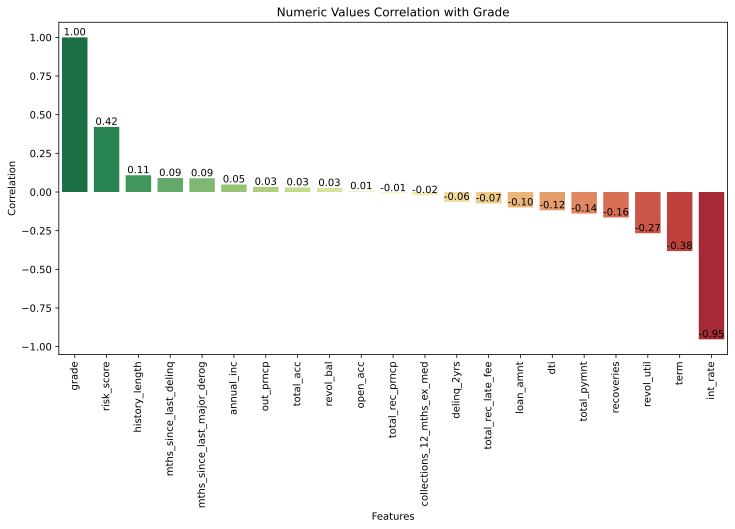

In [67]:
corr = num_data.corr()['grade'].sort_values(ascending=False)
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=corr.index, y=corr.values, palette="RdYlGn_r")
plt.xticks(rotation=90)
plt.title('Numeric Values Correlation with Grade')
plt.xlabel('Features')
plt.ylabel('Correlation')
for index, value in enumerate(corr.values):
    barplot.text(index, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()

Among the numeric values there is moderate correlation with the risk score - which is expected, since this is often one of the main indicators for decision making. In addition, length of the credit history has some correlation. On the other hand, interest rate has a very strong negative correlation with the grade. 

In [68]:
cat_cols_for_data = ['grade', 'emp_title', 'home_ownership', 'purpose', 'addr_state', 'application_type',
                     'year', 'month', 'emp_length']
cat_data = accept_data[cat_cols_for_data].copy()

In [69]:
grade_mapping = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
cat_data['grade'] = cat_data['grade'].replace(grade_mapping)
cat_cols2 = cat_data.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()

for col in cat_cols2:
    cat_data[col] = label_encoder.fit_transform(cat_data[col])


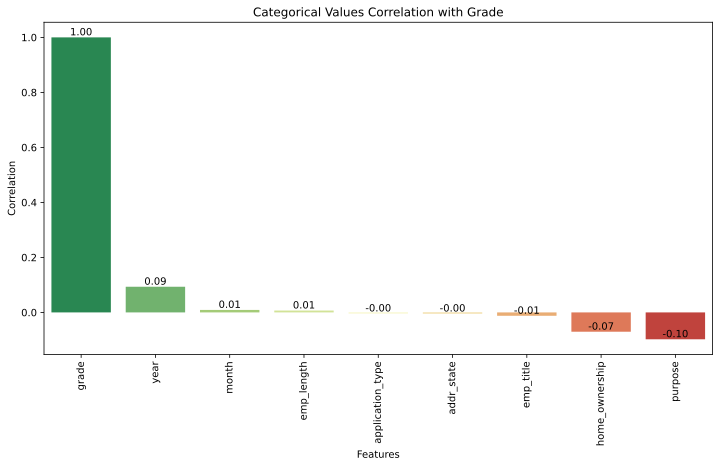

In [70]:
corr = cat_data.corr()['grade'].sort_values(ascending=False)
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x=corr.index, y=corr.values, palette="RdYlGn_r")
plt.xticks(rotation=90)
plt.title('Categorical Values Correlation with Grade')
plt.xlabel('Features')
plt.ylabel('Correlation')
for index, value in enumerate(corr.values):
    barplot.text(index, value, f'{value:.2f}', ha='center', va='bottom')
plt.show()

Unlike numeric values, categorical features do not have any strong or moderate corrlations with the grade. 

One of the main goals of this analysis is to predict the grade and sub-grade of the borrower. The risk assesment happens in three steps:

1. Evaluating user input data.
2. Evaluating external system data.
3. Deriving the features from the combination of the 1. and 2.

As a result of these steps the model has to be able to accept input data and return grade and sub-grade. Since user input and external systems data is 'given', next I will focus on calculating derived values that are important in grading - dti and risk score.

1. DTI - debt to income has 0,12 negative correlation with the grade value, which is comparetively weak, but amonth 5 top positively and negatively correlated values. The more per person owns, the higher is the value. In the dataset we are given the following information: new loan amount, new loan interest, new loan term, and DTI, which help us calculate other monthly payments that are not explicitly provided in the dataset. Deriving monthly payments, other than the new loan is important in predicting new loan grade. Although, I will use DTI as one of the parameters in modeling, however, for the user input data, I will assume that external monthly payments are received from the external credit resources, and then DTI is calculated for modeling.
2. Fico score is very important in defining the grade of the new loan. Apparently, the calculation of this feature is complex, and requires a lot of external information. According to the myfico site, credit companies buy this information about the potential lender from them (https://www.myfico.com/credit-education/whats-in-your-credit-score#:~:text=What's%20in%20my%20FICO%C2%AE,and%20credit%20mix%20(10%25)). I am not going to derive the risc score from the given data, but will asume that it is received from external source, along with user input and other external information. From the visual analysis of the data, we see that lenders club has FICO threshold equal to ~660 for loan to be possible, though not neceseraly granted. 

In [72]:
interest = accept_data['int_rate']/100/12
months = accept_data['term']
amnt = accept_data['loan_amnt']
accept_data['pmt'] = npf.pmt(interest, months, -amnt).round(2)

In [73]:
accept_data.head()

loan_amnt  term  int_rate hardship_flag grade sub_grade  \
0     3600.0    36     13.99             N     C        C4   
1    24700.0    36     11.99             N     C        C1   
2    20000.0    60     10.78             N     B        B4   
3    35000.0    60     14.85             N     C        C5   
4    10400.0    60     22.45             N     F        F1   

                     emp_title  emp_length home_ownership  annual_inc  \
0                      leadman        10.0       MORTGAGE     55000.0   
1                     Engineer        10.0       MORTGAGE     65000.0   
2                 truck driver        10.0       MORTGAGE     63000.0   
3  Information Systems Officer        10.0       MORTGAGE    110000.0   
4          Contract Specialist         3.0       MORTGAGE    104433.0   

              purpose addr_state    dti  delinq_2yrs  mths_since_last_delinq  \
0  debt_consolidation         PA   5.91          0.0                    30.0   
1      small_business         SD  16.06          1.0                     6.0   
2    home_improvement         IL  10.78          0.0                   227.0   
3  debt_consolidation         NJ  17.06          0.0                   227.0   
4      major_purchase         PA  25.37          1.0                    12.0   

   open_acc  revol_bal  revol_util  total_acc  out_prncp   total_pymnt  \
0       7.0     2765.0        29.7       13.0       0.00   4421.723917   
1      22.0    21470.0        19.2       38.0       0.00  25679.660000   
2       6.0     7869.0        56.2       18.0       0.00  22705.924294   
3      13.0     7802.0        11.6       17.0   15897.65  31464.010000   
4      12.0    21929.0        64.5       35.0       0.00  11740.500000   

   total_rec_prncp  total_rec_late_fee  recoveries  \
0          3600.00                 0.0         0.0   
1         24700.00                 0.0         0.0   
2         20000.00                 0.0         0.0   
3         19102.35                 0.0         0.0   
4         10400.00                 0.0         0.0   

   collections_12_mths_ex_med  mths_since_last_major_derog  policy_code  \
0                         0.0                         30.0          1.0   
1                         0.0                        227.0          1.0   
2                         0.0                        227.0          1.0   
3                         0.0                        227.0          1.0   
4                         0.0                        227.0          1.0   

  application_type  year  month  risk_score  history_length     pmt  
0       Individual  2015     12       677.0             150  123.02  
1       Individual  2015     12       717.0             194  820.28  
2        Joint App  2015     12       697.0             186  432.66  
3       Individual  2015     12       787.0              88  829.89  
4       Individual  2015     12       697.0             213  289.90

In [74]:
all_pmt = accept_data['annual_inc']/12*accept_data['dti']/100
accept_data['other_pmt'] = (all_pmt - accept_data['pmt']).round(2)
accept_data.drop(columns= 'pmt', axis=1, inplace=True)
accept_data.head()

loan_amnt  term  int_rate hardship_flag grade sub_grade  \
0     3600.0    36     13.99             N     C        C4   
1    24700.0    36     11.99             N     C        C1   
2    20000.0    60     10.78             N     B        B4   
3    35000.0    60     14.85             N     C        C5   
4    10400.0    60     22.45             N     F        F1   

                     emp_title  emp_length home_ownership  annual_inc  \
0                      leadman        10.0       MORTGAGE     55000.0   
1                     Engineer        10.0       MORTGAGE     65000.0   
2                 truck driver        10.0       MORTGAGE     63000.0   
3  Information Systems Officer        10.0       MORTGAGE    110000.0   
4          Contract Specialist         3.0       MORTGAGE    104433.0   

              purpose addr_state    dti  delinq_2yrs  mths_since_last_delinq  \
0  debt_consolidation         PA   5.91          0.0                    30.0   
1      small_business         SD  16.06          1.0                     6.0   
2    home_improvement         IL  10.78          0.0                   227.0   
3  debt_consolidation         NJ  17.06          0.0                   227.0   
4      major_purchase         PA  25.37          1.0                    12.0   

   open_acc  revol_bal  revol_util  total_acc  out_prncp   total_pymnt  \
0       7.0     2765.0        29.7       13.0       0.00   4421.723917   
1      22.0    21470.0        19.2       38.0       0.00  25679.660000   
2       6.0     7869.0        56.2       18.0       0.00  22705.924294   
3      13.0     7802.0        11.6       17.0   15897.65  31464.010000   
4      12.0    21929.0        64.5       35.0       0.00  11740.500000   

   total_rec_prncp  total_rec_late_fee  recoveries  \
0          3600.00                 0.0         0.0   
1         24700.00                 0.0         0.0   
2         20000.00                 0.0         0.0   
3         19102.35                 0.0         0.0   
4         10400.00                 0.0         0.0   

   collections_12_mths_ex_med  mths_since_last_major_derog  policy_code  \
0                         0.0                         30.0          1.0   
1                         0.0                        227.0          1.0   
2                         0.0                        227.0          1.0   
3                         0.0                        227.0          1.0   
4                         0.0                        227.0          1.0   

  application_type  year  month  risk_score  history_length  other_pmt  
0       Individual  2015     12       677.0             150     147.86  
1       Individual  2015     12       717.0             194      49.64  
2        Joint App  2015     12       697.0             186     133.29  
3       Individual  2015     12       787.0              88     733.94  
4       Individual  2015     12       697.0             213    1917.99

In [75]:
grade_mapping = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
accept_data['grade'] = accept_data['grade'].replace(grade_mapping)
accept_data.head()

loan_amnt  term  int_rate hardship_flag  grade sub_grade  \
0     3600.0    36     13.99             N      4        C4   
1    24700.0    36     11.99             N      4        C1   
2    20000.0    60     10.78             N      5        B4   
3    35000.0    60     14.85             N      4        C5   
4    10400.0    60     22.45             N      1        F1   

                     emp_title  emp_length home_ownership  annual_inc  \
0                      leadman        10.0       MORTGAGE     55000.0   
1                     Engineer        10.0       MORTGAGE     65000.0   
2                 truck driver        10.0       MORTGAGE     63000.0   
3  Information Systems Officer        10.0       MORTGAGE    110000.0   
4          Contract Specialist         3.0       MORTGAGE    104433.0   

              purpose addr_state    dti  delinq_2yrs  mths_since_last_delinq  \
0  debt_consolidation         PA   5.91          0.0                    30.0   
1      small_business         SD  16.06          1.0                     6.0   
2    home_improvement         IL  10.78          0.0                   227.0   
3  debt_consolidation         NJ  17.06          0.0                   227.0   
4      major_purchase         PA  25.37          1.0                    12.0   

   open_acc  revol_bal  revol_util  total_acc  out_prncp   total_pymnt  \
0       7.0     2765.0        29.7       13.0       0.00   4421.723917   
1      22.0    21470.0        19.2       38.0       0.00  25679.660000   
2       6.0     7869.0        56.2       18.0       0.00  22705.924294   
3      13.0     7802.0        11.6       17.0   15897.65  31464.010000   
4      12.0    21929.0        64.5       35.0       0.00  11740.500000   

   total_rec_prncp  total_rec_late_fee  recoveries  \
0          3600.00                 0.0         0.0   
1         24700.00                 0.0         0.0   
2         20000.00                 0.0         0.0   
3         19102.35                 0.0         0.0   
4         10400.00                 0.0         0.0   

   collections_12_mths_ex_med  mths_since_last_major_derog  policy_code  \
0                         0.0                         30.0          1.0   
1                         0.0                        227.0          1.0   
2                         0.0                        227.0          1.0   
3                         0.0                        227.0          1.0   
4                         0.0                        227.0          1.0   

  application_type  year  month  risk_score  history_length  other_pmt  
0       Individual  2015     12       677.0             150     147.86  
1       Individual  2015     12       717.0             194      49.64  
2        Joint App  2015     12       697.0             186     133.29  
3       Individual  2015     12       787.0              88     733.94  
4       Individual  2015     12       697.0             213    1917.99

In [77]:
grade_data = accept_data.copy()
grade_data = grade_data.drop(columns = ['sub_grade', 'int_rate'])
grade_data.head()

loan_amnt  term hardship_flag  grade                    emp_title  \
0     3600.0    36             N      4                      leadman   
1    24700.0    36             N      4                     Engineer   
2    20000.0    60             N      5                 truck driver   
3    35000.0    60             N      4  Information Systems Officer   
4    10400.0    60             N      1          Contract Specialist   

   emp_length home_ownership  annual_inc             purpose addr_state  \
0        10.0       MORTGAGE     55000.0  debt_consolidation         PA   
1        10.0       MORTGAGE     65000.0      small_business         SD   
2        10.0       MORTGAGE     63000.0    home_improvement         IL   
3        10.0       MORTGAGE    110000.0  debt_consolidation         NJ   
4         3.0       MORTGAGE    104433.0      major_purchase         PA   

     dti  delinq_2yrs  mths_since_last_delinq  open_acc  revol_bal  \
0   5.91          0.0                    30.0       7.0     2765.0   
1  16.06          1.0                     6.0      22.0    21470.0   
2  10.78          0.0                   227.0       6.0     7869.0   
3  17.06          0.0                   227.0      13.0     7802.0   
4  25.37          1.0                    12.0      12.0    21929.0   

   revol_util  total_acc  out_prncp   total_pymnt  total_rec_prncp  \
0        29.7       13.0       0.00   4421.723917          3600.00   
1        19.2       38.0       0.00  25679.660000         24700.00   
2        56.2       18.0       0.00  22705.924294         20000.00   
3        11.6       17.0   15897.65  31464.010000         19102.35   
4        64.5       35.0       0.00  11740.500000         10400.00   

   total_rec_late_fee  recoveries  collections_12_mths_ex_med  \
0                 0.0         0.0                         0.0   
1                 0.0         0.0                         0.0   
2                 0.0         0.0                         0.0   
3                 0.0         0.0                         0.0   
4                 0.0         0.0                         0.0   

   mths_since_last_major_derog  policy_code application_type  year  month  \
0                         30.0          1.0       Individual  2015     12   
1                        227.0          1.0       Individual  2015     12   
2                        227.0          1.0        Joint App  2015     12   
3                        227.0          1.0       Individual  2015     12   
4                        227.0          1.0       Individual  2015     12   

   risk_score  history_length  other_pmt  
0       677.0             150     147.86  
1       717.0             194      49.64  
2       697.0             186     133.29  
3       787.0              88     733.94  
4       697.0             213    1917.99

In [78]:
X = grade_data.drop(['grade'], axis=1)
y = grade_data['grade']

print("Original class distribution:", Counter(y))

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=69)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Undersampled class distribution:", Counter(y_resampled))

undersampled_data = pd.concat([X_resampled, y_resampled], axis=1)

Original class distribution: Counter({5: 662649, 4: 648957, 6: 432519, 3: 323708, 2: 135381, 1: 41708, 0: 12124})
Undersampled class distribution: Counter({0: 12124, 1: 12124, 2: 12124, 3: 12124, 4: 12124, 5: 12124, 6: 12124})


In [132]:
reduced_grade_data =undersampled_data.sample(n=5000)

In [133]:
results = evaluate_models(reduced_grade_data, 'grade')
results

Model  Accuracy  Precision  Recall        F1
0  Decision Tree     0.276   0.287225   0.276  0.280357
1  Random Forest     0.326   0.320551   0.326  0.315359
2            SVM     0.350   0.346477   0.350  0.339038
3        XGBoost     0.342   0.346481   0.342  0.341698

I will try usind dimentionality reduction technique to improve the results. For that I have created a separate function.

In [135]:
results = reduced_evaluate_models(reduced_grade_data, 'grade', 10)
results

Model  Accuracy  Precision  Recall        F1
0  Decision Tree     0.268   0.275734   0.268  0.270487
1  Random Forest     0.318   0.314514   0.318  0.311646
2            SVM     0.336   0.326462   0.336  0.314212
3        XGBoost     0.324   0.327420   0.324  0.323783

Dimentionality reduction, did not improve the model. In fact, it even reduced the measures. I will try reducing the number of features that are being passed into model. For that, I will use three techniques to try identifying, which features are important for the model. 

Since previous model test best performed with XGBoost model, I will use it for feature importance analysis.

In [136]:

X = reduced_grade_data.drop(['grade', 'encoded'], axis=1)
y = reduced_grade_data['grade']

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

numerical_transformer = SimpleImputer(strategy='mean')
X[numerical_features] = numerical_transformer.fit_transform(X[numerical_features])

categorical_transformer = SimpleImputer(strategy='most_frequent')
X[categorical_features] = categorical_transformer.fit_transform(X[categorical_features])

X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

model = XGBClassifier(seed=0)
result = model.fit(X_train, y_train)


I will use three techniques - shap, feature importance method, and permutation importance function. 

In [86]:
explainer = shap.Explainer(model, X_train)

sample_index = 0

shap_values = explainer.shap_values(X_test.iloc[sample_index])

shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[sample_index])


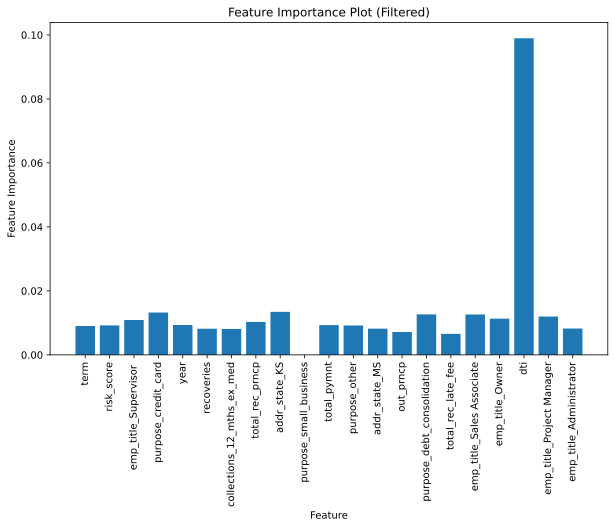

In [87]:
feature_importance = model.feature_importances_
feature_names = X.columns
threshold = 0.01 # Adjust the threshold as needed
important_features = feature_names[feature_importance > threshold]
sorted_idx = np.argsort(feature_importance[feature_importance > threshold])[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), important_features[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance Plot (Filtered)')
plt.show()

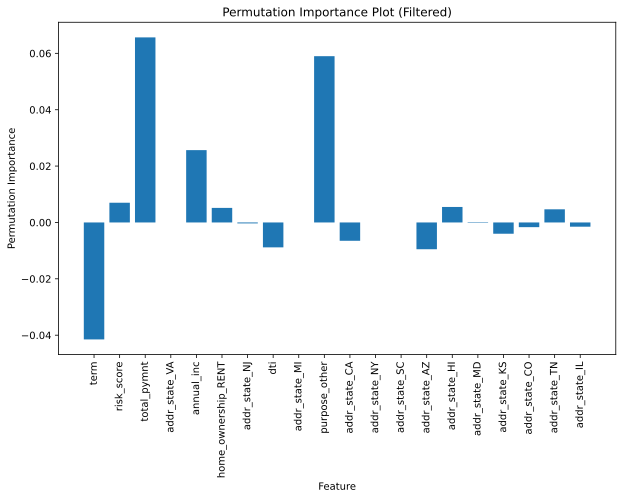

In [131]:
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

threshold = 0.0 
important_features = X_test.columns[perm_importance.importances_mean > threshold]
sorted_idx = np.argsort(perm_importance.importances_mean[perm_importance.importances_mean > threshold])[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.xticks(range(len(sorted_idx)), important_features[sorted_idx], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.title('Permutation Importance Plot (Filtered)')
plt.show()

Based on correlation and three different techniques to identify the important features for the credit grade, I chose the following features to continue the modeling: risk score, dti, annual income, total payment, credit term, purpose, employment term, and home ownership as the parameters, which I will use in determining the grade and subgrade of the borrower.

In [88]:
selected_features_grade = [
    "loan_amnt", "term", 'total_pymnt', "grade", "emp_length", "home_ownership",
    "annual_inc", "purpose", "dti", "risk_score", "history_length", 'addr_state', 'recoveries'
]
reduced_features_data = accept_data[selected_features_grade]
reduced_features_data.head()


loan_amnt  term   total_pymnt  grade  emp_length home_ownership  \
0     3600.0    36   4421.723917      4        10.0       MORTGAGE   
1    24700.0    36  25679.660000      4        10.0       MORTGAGE   
2    20000.0    60  22705.924294      5        10.0       MORTGAGE   
3    35000.0    60  31464.010000      4        10.0       MORTGAGE   
4    10400.0    60  11740.500000      1         3.0       MORTGAGE   

   annual_inc             purpose    dti  risk_score  history_length  \
0     55000.0  debt_consolidation   5.91       677.0             150   
1     65000.0      small_business  16.06       717.0             194   
2     63000.0    home_improvement  10.78       697.0             186   
3    110000.0  debt_consolidation  17.06       787.0              88   
4    104433.0      major_purchase  25.37       697.0             213   

  addr_state  recoveries  
0         PA         0.0  
1         SD         0.0  
2         IL         0.0  
3         NJ         0.0  
4         PA         0.0

In [92]:
X = reduced_features_data.drop(['grade'], axis=1)
y = reduced_features_data['grade']

print("Original class distribution:", Counter(y))

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=69)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Undersampled class distribution:", Counter(y_resampled))

undersampled_data = pd.concat([X_resampled, y_resampled], axis=1)

Original class distribution: Counter({5: 662649, 4: 648957, 6: 432519, 3: 323708, 2: 135381, 1: 41708, 0: 12124})
Undersampled class distribution: Counter({0: 12124, 1: 12124, 2: 12124, 3: 12124, 4: 12124, 5: 12124, 6: 12124})


After testing with several different sample sizes, I decided to use 15000 records. The larger number takes much longer time and does not increase accuracy measures noticeable. 

In [90]:
reduced_grade_features_data = undersampled_data.sample(n=15000)

In [95]:
distribution_check = reduced_grade_features_data['grade']
print("Original class distribution:", Counter(distribution_check))

Original class distribution: Counter({2: 2233, 3: 2194, 1: 2168, 4: 2128, 6: 2115, 5: 2083, 0: 2079})


After reduced sample distribution test, we see that the grade classes are quite balanced. 

No I will test the models with the reduced and balanced data.

In [96]:
results = evaluate_models(reduced_grade_features_data, 'grade')
results

Model  Accuracy  Precision    Recall        F1
0  Decision Tree  0.267667   0.262553  0.267667  0.264486
1  Random Forest  0.331333   0.316117  0.331333  0.319939
2            SVM  0.347667   0.332740  0.347667  0.332033
3        XGBoost  0.351000   0.336325  0.351000  0.339998

XGBoost model showed the best results. I will later tune hyperparameters seeking for the better results. 

Now I will train the models for sub_grade predition. First, I will work with full set of assumed pre-decision data.

In [97]:

selected_features_sub_grade = [
    "loan_amnt", "term", "grade", 'sub_grade', "emp_title", "emp_length", "home_ownership",
    "annual_inc", "purpose", "addr_state", "dti", "delinq_2yrs", "mths_since_last_delinq",
    "open_acc", "revol_bal", "revol_util", "total_acc", "out_prncp", "total_pymnt",
    "total_rec_prncp", "total_rec_late_fee", "recoveries", "collections_12_mths_ex_med",
    "mths_since_last_major_derog", "policy_code", "application_type", "year",
    "month", "risk_score", "history_length", "other_pmt"
]
features_data_sub = accept_data[selected_features_sub_grade]


In [98]:
X = features_data_sub.drop(['sub_grade'], axis=1)
y = features_data_sub['sub_grade']

print("Original class distribution:", Counter(y))

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=25)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

print("Undersampled class distribution:", Counter(y_resampled))

undersampled_data_sub = pd.concat([X_resampled, y_resampled], axis=1)

Original class distribution: Counter({'C1': 145667, 'B5': 140089, 'B4': 139598, 'B3': 131348, 'C2': 130893, 'C3': 128991, 'C4': 126882, 'B2': 126447, 'B1': 125167, 'C5': 116524, 'A5': 107508, 'A4': 95758, 'A1': 86690, 'D1': 81632, 'A3': 73085, 'D2': 72740, 'A2': 69478, 'D3': 64658, 'D4': 56772, 'D5': 47906, 'E1': 33532, 'E2': 29865, 'E3': 26650, 'E4': 22711, 'E5': 22623, 'F1': 13386, 'F2': 9283, 'F3': 7771, 'F4': 6112, 'F5': 5156, 'G1': 4088, 'G2': 2677, 'G3': 2091, 'G4': 1708, 'G5': 1560})
Undersampled class distribution: Counter({'A1': 1560, 'A2': 1560, 'A3': 1560, 'A4': 1560, 'A5': 1560, 'B1': 1560, 'B2': 1560, 'B3': 1560, 'B4': 1560, 'B5': 1560, 'C1': 1560, 'C2': 1560, 'C3': 1560, 'C4': 1560, 'C5': 1560, 'D1': 1560, 'D2': 1560, 'D3': 1560, 'D4': 1560, 'D5': 1560, 'E1': 1560, 'E2': 1560, 'E3': 1560, 'E4': 1560, 'E5': 1560, 'F1': 1560, 'F2': 1560, 'F3': 1560, 'F4': 1560, 'F5': 1560, 'G1': 1560, 'G2': 1560, 'G3': 1560, 'G4': 1560, 'G5': 1560})


After several attemps with different sample proportions, I decided to stay with sample size of 20000 entries.

In [99]:
reduced_sub_grade_features_data = undersampled_data_sub.sample(n=20000)

In [102]:
distribution_check = reduced_sub_grade_features_data['sub_grade']
print("Original class distribution:", Counter(distribution_check))

Original class distribution: Counter({'B4': 618, 'D2': 618, 'C4': 606, 'E2': 599, 'G1': 596, 'D4': 589, 'E4': 585, 'E5': 583, 'G3': 583, 'G5': 581, 'B2': 578, 'E3': 577, 'B3': 576, 'A1': 576, 'C2': 576, 'B5': 572, 'A3': 570, 'B1': 569, 'F4': 569, 'D1': 568, 'F5': 567, 'A5': 565, 'G2': 562, 'D5': 561, 'A2': 561, 'F3': 559, 'G4': 557, 'C3': 553, 'A4': 552, 'D3': 551, 'F1': 551, 'E1': 547, 'C5': 543, 'F2': 542, 'C1': 540})


Again, we see that the distribution of the sub_grade classed is quite well balanced.

Now, I will fit the models with the data.

In [103]:
results = evaluate_models(reduced_sub_grade_features_data, 'sub_grade')
results

Model  Accuracy  Precision   Recall        F1
0  Decision Tree   0.22125   0.222300  0.22125  0.220755
1  Random Forest   0.16775   0.167039  0.16775  0.164174
2            SVM   0.23175   0.230923  0.23175  0.224980
3        XGBoost   0.23775   0.239776  0.23775  0.237855

Now, I will reduce the number of features based on feature importance analysis.

In [104]:

reduced_features_sub_grade = [
    "loan_amnt", "term", "grade", 'sub_grade', "emp_length", "home_ownership",
    "purpose", "addr_state", "dti", 
    "recoveries", 
    "mths_since_last_major_derog", "policy_code", "application_type", 
    "risk_score", "history_length", "other_pmt"
]
reduced_features_data_sub = undersampled_data_sub[reduced_features_sub_grade]

In [105]:
reduced_sub_grade_features_data = reduced_features_data_sub.sample(n=40000)

In [106]:
results = evaluate_models(reduced_sub_grade_features_data, 'sub_grade')
results

Model  Accuracy  Precision    Recall        F1
0  Decision Tree  0.211500   0.212330  0.211500  0.211287
1  Random Forest  0.217125   0.217534  0.217125  0.216419
2            SVM  0.233125   0.233333  0.233125  0.228274
3        XGBoost  0.227875   0.228429  0.227875  0.227443

Even with the reduced features, the models did not show impresive results.

For grade prdiction xgboost showed best results, while for sub-grade SVM model. 

Since grade prediction showed better resuls than subgrade, I will continue working only with the grade data. 

For grade prediction, I will use XGBoots model since it showed the best results. I will tune hyperparameter for better performance.

In [109]:

X = reduced_grade_features_data.drop(['grade', 'encoded'], axis=1)
y = reduced_grade_features_data['grade']

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

numeric_transformer = 'passthrough'

categorical_transformer = Pipeline(steps=[
    ('targetencoder', ce.TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(seed=0))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=69)

param_grid = {
    'classifier__n_estimators': [30, 40, 50, 60, 70, 80, 90, 100],
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__learning_rate': [0.01, 0.1, 0.2, 0.3]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='recall',
    cv=10,
    verbose=1,
    n_jobs=-1,
    random_state=0
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best Hyperparameters: {'classifier__n_estimators': 30, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1}


In [110]:
best_estimator = random_search.best_estimator_
best_estimator.fit(X_train, y_train)
y_pred = best_estimator.predict(X_test)
recall = recall_score(y_test, y_pred, average='macro')
print("Recall Score:", recall)


Recall Score: 0.34322604903421305


In [111]:
api_call = {
    "loan_amnt": 10000,
    "term": 36,
    "total_pymnt": 500,
    "emp_length": 10,
    "home_ownership": "RENT",
    "annual_inc": 100000,
    "purpose": "credit_card",
    "dti": 80,
    "risk_score": 675,
    "history_length": 180,
    "addr_state": "MC",
    "recoveries": 0
}

api_call_df = pd.DataFrame([api_call])

best_estimator = random_search.best_estimator_

numerical_features = ['loan_amnt', 'term', 'total_pymnt', 'emp_length', 'annual_inc', 'dti', 'risk_score', 'history_length', 'recoveries']
categorical_fearures = ["home_ownership","purpose","addr_state"]

categorical_transformer = best_estimator['preprocessor'].transformers_[1][1]
api_call_df[categorical_features] = categorical_transformer.transform(api_call_df[categorical_features])

y_pred = best_estimator.predict(api_call_df)

grade_mapping = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
reverse_grade_mapping = {v: k for k, v in grade_mapping.items()}

predicted_letter_grades = [reverse_grade_mapping.get(grade, 'Unknown') for grade in y_pred]

    # Print the predicted letter grades
print("Predicted Letter Grades:", predicted_letter_grades)


Predicted Letter Grades: ['D']


After fitting the model with hyperparameters, the recall value improved. Perhaps this is because of the random state. The value is very high. 

I will test the model on the assummed user input data.

I will store the model into pickle file for deploying.

In [112]:
data = {"model": best_estimator}
with open('model_steps.pkl', 'wb') as f:
    pickle.dump(data, f)

Now, I will call the function and test it.

In [113]:
with open('model_steps.pkl', 'rb') as f:
    data = pickle.load(f)
    
test_mod = data['model'] 

In [114]:
api_call = {
    "loan_amnt": 10000,
    "term": 36,
    "total_pymnt": 500,
    "emp_length": 10,
    "home_ownership": "RENT",
    "annual_inc": 100000,
    "purpose": "credit_card",
    "dti": 80,
    "risk_score": 675,
    "history_length": 180,
    "addr_state": "MC",
    "recoveries": 0
}

api_call_df = pd.DataFrame([api_call])

best_estimator = random_search.best_estimator_

numerical_features = ['loan_amnt', 'term', 'total_pymnt', 'emp_length', 'annual_inc', 'dti', 'risk_score', 'history_length', 'recoveries']
categorical_fearures = ["home_ownership","purpose","addr_state"]

categorical_transformer = best_estimator['preprocessor'].transformers_[1][1]
api_call_df[categorical_features] = categorical_transformer.transform(api_call_df[categorical_features])

y_pred = test_mod.predict(api_call_df)

grade_mapping = {'A': 6, 'B': 5, 'C': 4, 'D': 3, 'E': 2, 'F': 1, 'G': 0}
reverse_grade_mapping = {v: k for k, v in grade_mapping.items()}

predicted_letter_grades = [reverse_grade_mapping.get(grade, 'Unknown') for grade in y_pred]

    # Print the predicted letter grades
print("Predicted Letter Grades:", predicted_letter_grades)


Predicted Letter Grades: ['D']


I got the same result. The model is well saved and can be used in production.

# VI. Conclusion

The task required me to see if the historically collected data could serve well in predicting the features that incfluence loan acceptance or rejection. In addition, the historical data should have helpe in risk grade and sub_grade prodicting. Based on the extensive analysis, I conclude that all of these tasks cannot be achieve with the desired accuracy.

To predict the decision both accept and reject dataset had to have more of the user and external resource data. Reject dataset was very limited in terms of features.

The grade preditiction did not achieve high accuracy results, even those I separated the predecision data from after decision data to avoide data leakage. None of the technieques for feature selection helped to improve the result.

The XGBoost model helped to achieve ~35% recall value. I deployed this best model to Google Cloud as a service. With the achieved accuracy this model can predict the grade of the borrower. 




## VII. Recomendations
Instead of working with extensive data in terms of features and number of records, I would accumulate only the data that takes part in the initial grade and sub_grade prediction. Also, for the rejected loans part I would also provide more parameters that have direct impact on the decision.